In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
from pmlb import fetch_data

X, y = fetch_data('1199_BNG_echoMonths', return_X_y=True)

In [5]:
X.shape

(17496, 9)

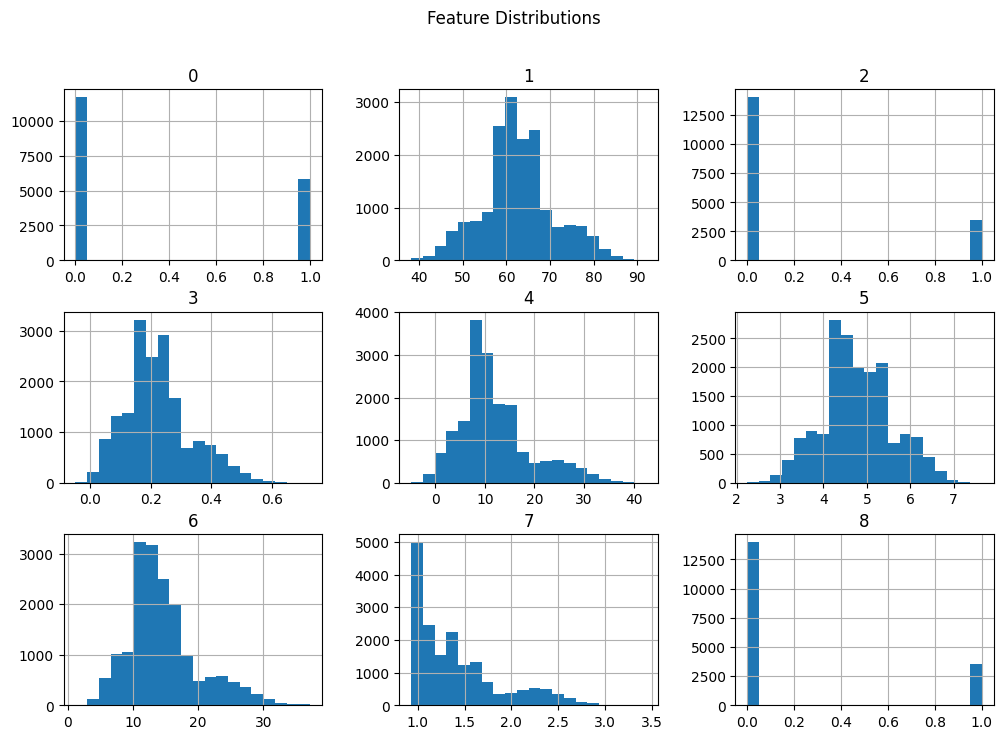

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_df = pd.DataFrame(X)
X_df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

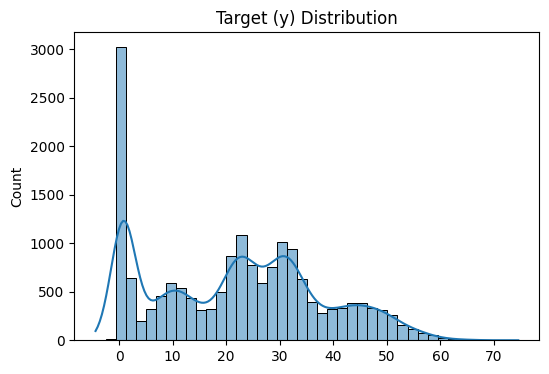

In [7]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

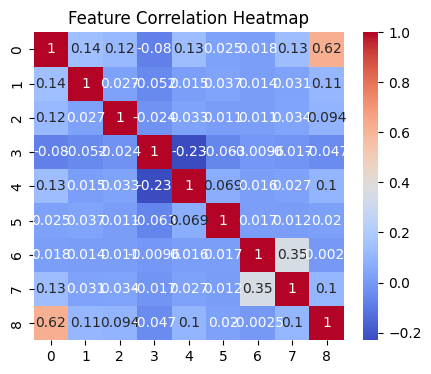

In [8]:
plt.figure(figsize=(5, 4))
corr = X_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.020678                 1.117711             1.263661   
1                  1.052284                 1.047965             1.076793   
2                  1.019866                 1.018817             1.073691   
3                  1.040959                 1.039862             1.136446   
4                  1.076091                 1.056341             1.124914   
mean               1.041975                 1.056139             1.135101   
std                0.023525                 0.037134             0.077143   

      DefaultBART_Rhat_RMSE  
0                  1.188104  
1                  1.238458  
2                  1.368306  
3                  1.592095  
4                  1.268651  
mean               1.331123  
std                0.160026  


In [10]:
rhat_df.to_csv("results/real6_echoMonths_rhat.csv", index=False)

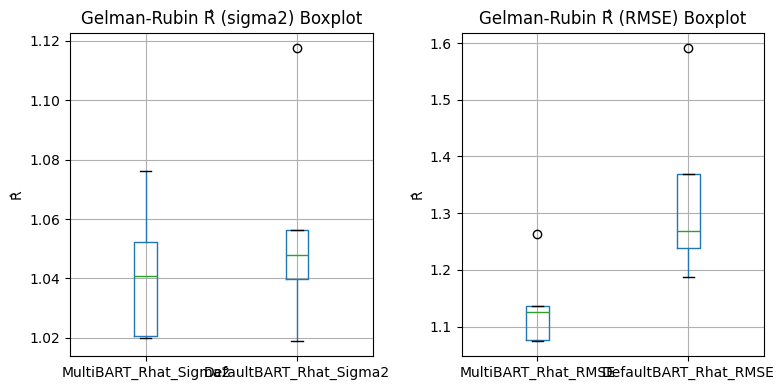

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

test_mse:
       bart_mtmh        bart         btz         sto          rf         xgb
0     127.572259  130.072390  128.896567  131.466599  132.644593  139.323217
1     132.404253  132.159629  132.698416  134.597460  135.221860  142.761038
2     127.834203  129.926204  129.785157  132.803806  134.094306  139.665325
3     130.242454  129.852001  130.865298  132.350288  136.009708  142.592322
4     130.070915  130.578625  131.089606  134.425194  134.661939  142.401405
5     132.539516  133.321186  133.905440  136.183479  137.830949  144.409112
6     127.734591  129.197288  129.154672  130.558515  130.075645  143.240277
7     133.634302  134.346144  135.338529  135.652156  137.396965  146.489538
8     129.380735  131.442310  132.440428  133.459411  134.223581  144.326072
9     126.746048  126.402124  126.890078  127.769123  129.732321  139.346478
mean  129.815928  130.729790  131.106419  132.926603  134.189187  142.455479
std     2.400257    2.243361    2.545885    2.539544    2.735311  

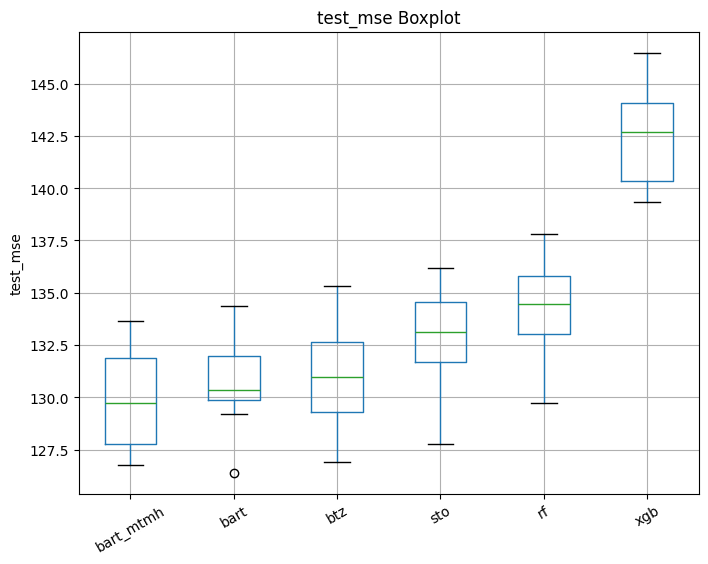

train_mse:
       bart_mtmh        bart         btz         sto         rf        xgb
0     115.055325  123.604708  125.820258  128.946803  18.837764  60.015500
1     114.454027  122.183093  126.047821  128.273528  18.643544  56.621137
2     116.561055  123.630702  125.360341  129.646602  18.682658  60.429968
3     115.327693  123.455267  125.596900  129.544888  18.630229  59.054943
4     115.978441  123.492477  126.416403  129.069002  18.653725  59.621118
5     113.838086  122.065385  124.980261  128.811442  18.613275  59.194286
6     115.863361  123.644791  126.255678  129.561876  18.792801  60.125988
7     115.356417  122.746472  124.796219  127.542899  18.492577  59.351145
8     115.583880  124.167152  126.338806  130.135675  18.767559  57.660885
9     116.378855  123.931802  127.658212  129.857150  18.807122  58.739761
mean  115.439714  123.292185  125.927090  129.138987  18.692126  59.081473
std     0.838909    0.715768    0.826322    0.785709   0.107524   1.171292



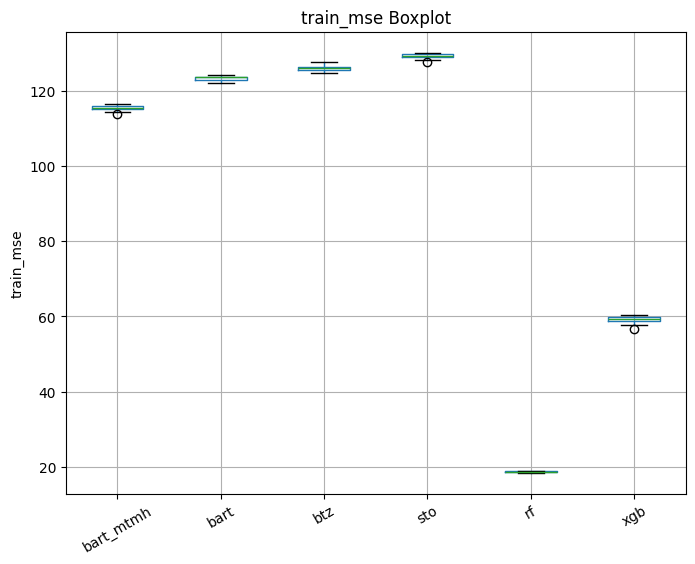

pi_length:
      bart_mtmh       bart        btz         sto
0     43.715116  44.154568  44.790197  538.578001
1     43.590443  43.883774  44.843689  543.390740
2     43.934752  44.254943  44.639626  537.870959
3     43.674066  44.219114  44.783513  541.261212
4     43.796130  44.132811  44.719864  542.663252
5     43.522682  43.982644  44.638270  543.433397
6     43.967891  44.275953  44.761456  535.423500
7     43.623464  43.985959  44.628715  532.366235
8     43.785546  44.226788  44.812849  549.771138
9     43.985922  44.165255  45.196682  552.348284
mean  43.759601  44.128181  44.781486  541.710672
std    0.163253   0.132971   0.165157    6.114044



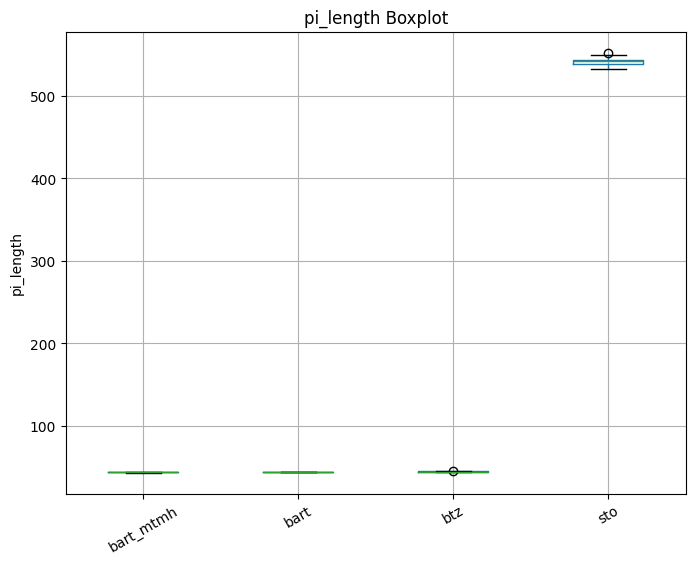

coverage:
      bart_mtmh      bart       btz       sto
0      0.934614  0.936214  0.943530  0.997714
1      0.930041  0.933699  0.938957  0.997714
2      0.937814  0.939186  0.942844  0.998400
3      0.935985  0.938043  0.942387  0.999543
4      0.932327  0.939872  0.941472  0.998628
5      0.930956  0.935299  0.939643  0.999314
6      0.943301  0.942387  0.943759  0.999086
7      0.933699  0.937357  0.943759  0.998628
8      0.936671  0.938272  0.941244  0.998628
9      0.942615  0.942615  0.948788  0.997485
mean   0.935802  0.938294  0.942638  0.998514
std    0.004498  0.002869  0.002730  0.000701



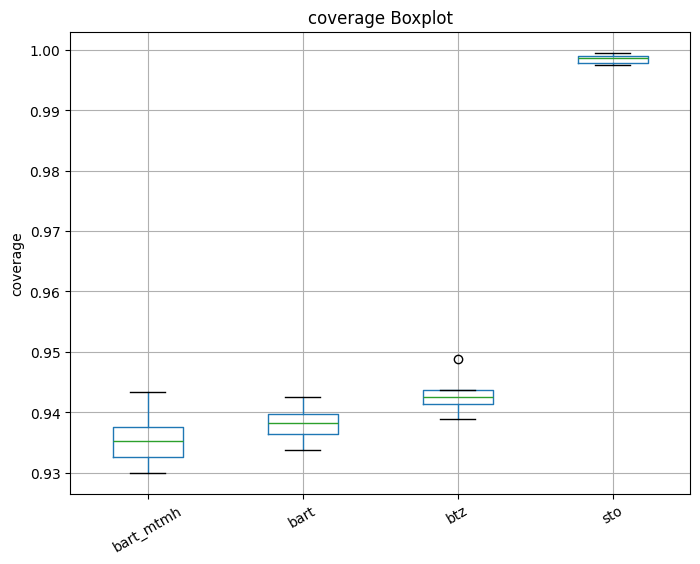

train_time:
       bart_mtmh       bart        btz         sto         rf       xgb
0     475.237875  62.171082  43.589426  142.792417  10.791686  0.206916
1     476.109311  62.579862  45.132235  141.696965  10.843629  0.192665
2     484.440476  74.073112  42.914058  138.110604  11.008065  0.233326
3     474.449608  61.496860  42.530185  143.897333  10.889167  0.308832
4     476.284610  61.362754  44.005131  142.508104  10.829002  0.194925
5     510.428763  77.842415  33.874104  151.152139  11.101198  0.090598
6     528.752062  89.869073  34.421261  144.520874  11.224108  0.105449
7     494.822503  66.950393  32.750901  154.084632  11.652616  0.090982
8     492.727839  66.636639  34.775771  155.072539  11.640997  0.112092
9     529.244788  97.101448  35.085145  139.766194   9.957359  0.108801
mean  494.249784  72.008364  38.907822  145.360180  10.993783  0.164459
std    21.553570  12.696872   5.064875    5.951965   0.482286  0.074004



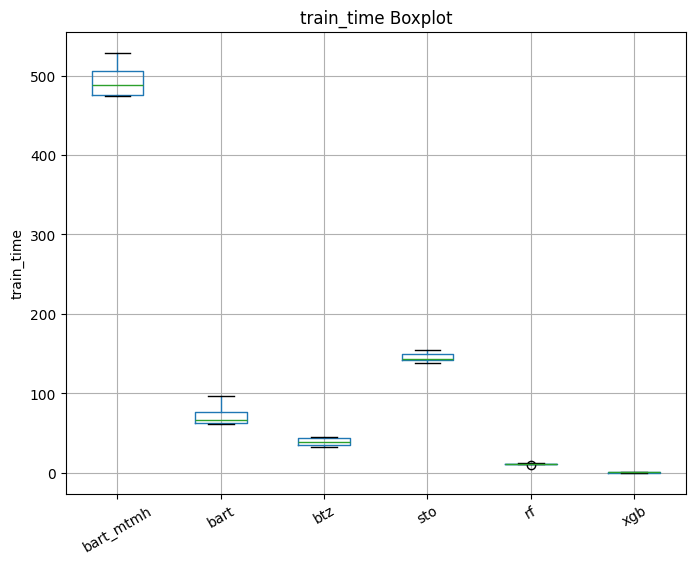

In [9]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [10]:
for k, v in mse_results.items():
    csv_name = f"results/real6_echoMonths_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [12]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real6_echoMonths_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1,5,10,50,100],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real6_echoMonths_tries.csv", index=False)

In [ ]:
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE    Test_MSE  Coverage   Train_Time
0            1     1.064726   1.329069  130.931802  0.938637   104.511811
1            5     1.035499   1.270686  129.912533  0.936534   262.978942
2           10     1.041975   1.135101  129.084843  0.935482   458.400184
3           50     1.027130   1.126739  129.504468  0.934156  2168.798357
4          100     1.068867   1.103707  129.921694  0.933791  4685.248563
